## Random Forest Model to Predict pIC50 of SARS-CoV 3CL protease inhibitors

The data was imported from chEMBL database using Datawarrior: http://www.openmolecules.org/datawarrior/ 
                                Gashaw M. Goshu       8/2/2020

In [99]:
import sklearn
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from rdkit.Avalon import pyAvalonTools

In [2]:
# pIC50 data obtained from ChEMBL database
dataset = pd.read_csv('D:/3CLprotease_inhibitors_133.csv')

In [3]:
  X, y  = np.array(dataset['Smiles']), np.array(dataset['pIC50'])    

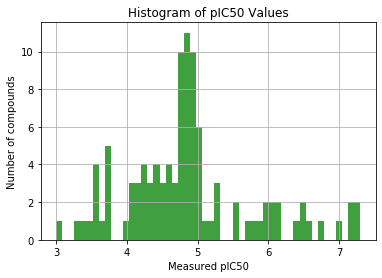

In [7]:
%matplotlib inline
pIC50s = np.array(dataset["pIC50"])
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [9]:
# Calculating Morgan fingerprints for training sets
train_morgan_fps = []
train_info=[]

for i in X_train:
    mol = Chem.MolFromSmiles(i) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    train_morgan_fps.append(temp)
    train_info.append(info)     
   

In [10]:
# Calculating morgan, rdkit and avalon fingerprints for test sets
test_morgan_fps = []
test_info=[]
    
for j in X_test:
    mol = Chem.MolFromSmiles(j) 
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    test_morgan_fps.append(temp)
    test_info.append(info)
   

In [71]:
rf = RandomForestRegressor(random_state=42,n_estimators=500)

In [88]:
# Data preprocessing using pipeline 
pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('model', rf)])

In [89]:
# Model Training and prediction
pipe.fit(train_morgan_fps,y_train) # training using 70% of the data
rf_prediction_mr = pipe.predict(test_morgan_fps) # predicting yield for 30% of the data

In [90]:
#Model accuracy using root mean square error 
rmse_mr = np.sqrt(mean_squared_error(y_test, rf_prediction_mr)) 
print('rmse:', rmse_mr)

rmse: 0.48664504078889675


In [91]:
# R^2 (coefficient of determination) regression score function: 
R2_mr =r2_score(y_test, rf_prediction_mr)
print('R^2:', R2_mr)

R^2: 0.7582312950525038


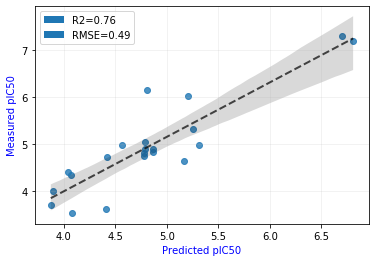

In [92]:
import matplotlib.patches as mpatches
sn.regplot(x=rf_prediction_mr, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted pIC50', color='blue')
plt.ylabel('Measured pIC50', color ='blue')
plt.grid(alpha=0.2)
R2_mr = mpatches.Patch(label='R2={:04.2f}'.format(R2_mr))
rmse_mr = mpatches.Patch(label='RMSE={:04.2f}'.format(rmse_mr))
plt.legend(handles=[R2_mr, rmse_mr])

In [101]:
print(f"=======================")
print(f"        pIC50    ")
print(f"-----------------------")
print(f"Measured  | Predicted ")
print(f"=======================")
for x in range(len(rf_prediction_mr)):
    print('{:04.2f}'.format(y_test[x]) + " ---------> " + '{:04.2f}'.format(rf_prediction_mr[x]))

        pIC50    
-----------------------
Measured  | Predicted 
4.40 ---------> 4.04
4.35 ---------> 4.07
7.20 ---------> 6.81
4.89 ---------> 4.87
5.04 ---------> 4.78
3.70 ---------> 3.87
6.02 ---------> 5.20
3.52 ---------> 4.08
4.72 ---------> 4.42
4.80 ---------> 4.78
4.63 ---------> 5.17
4.97 ---------> 5.32
6.15 ---------> 4.81
3.60 ---------> 4.41
4.74 ---------> 4.78
4.82 ---------> 4.87
5.32 ---------> 5.26
7.30 ---------> 6.70
4.00 ---------> 3.89
4.97 ---------> 4.56
4.90 ---------> 4.79


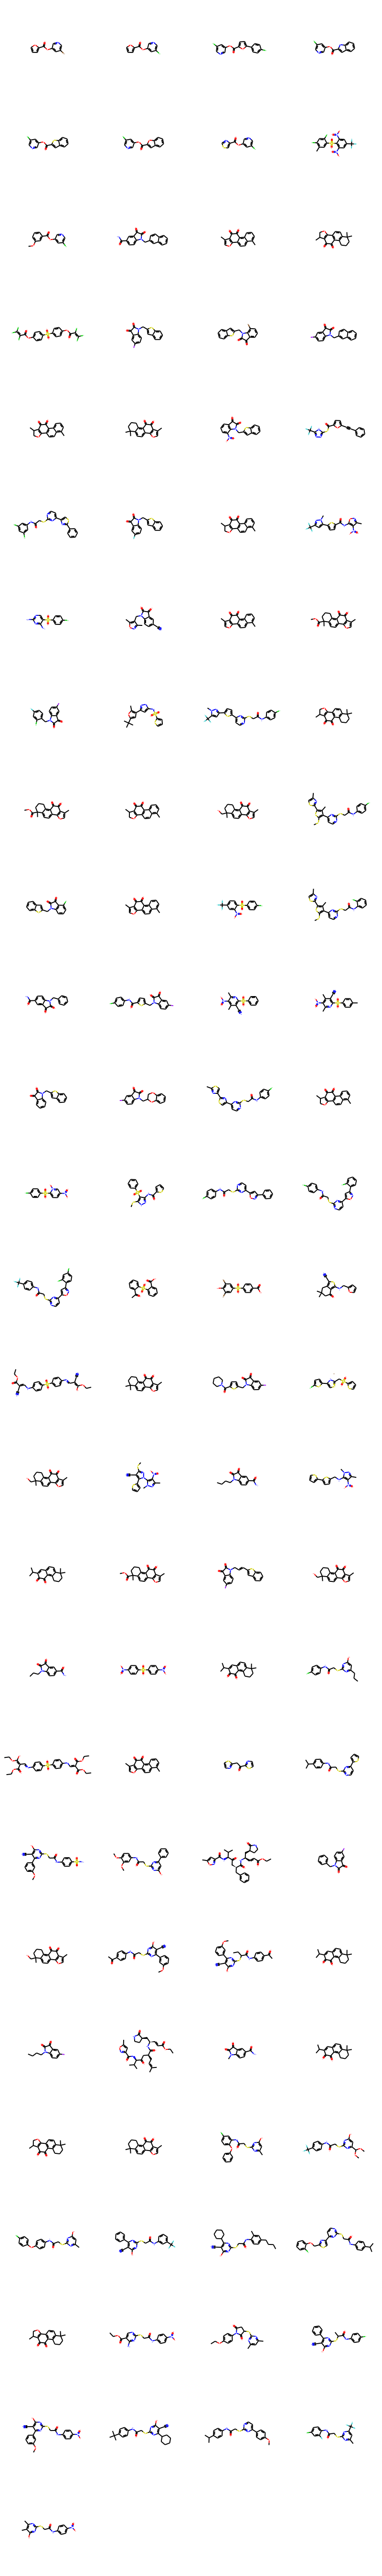

In [6]:
# Print structure of compounds

from rdkit.Chem import Draw
mol = [Chem.MolFromSmiles(i) for i in X]

img=Draw.MolsToGridImage(mol,molsPerRow=4,maxMols=200)   
img

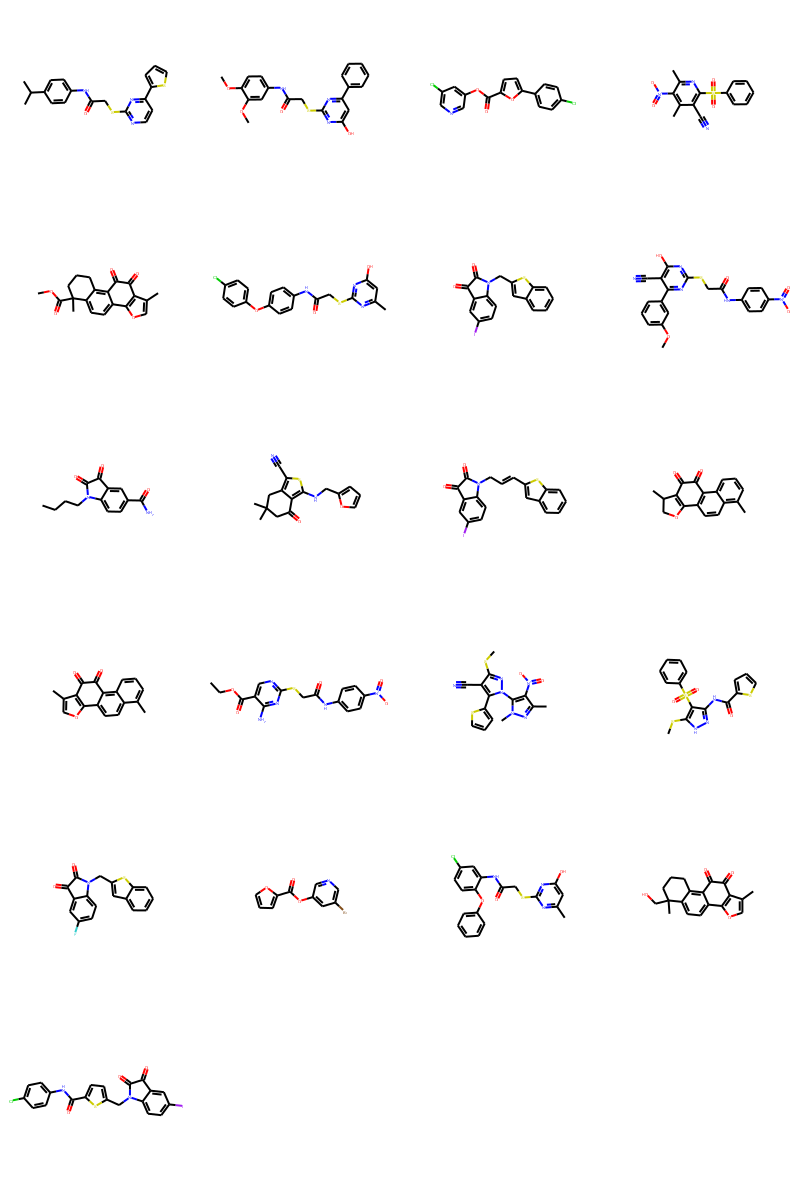

In [95]:
# structure of the test compounds 
mol = [Chem.MolFromSmiles(i) for i in X_test]

img=Draw.MolsToGridImage(mol,molsPerRow=4,maxMols=200)   
img

In [96]:
# Saving the model
from sklearn.externals import joblib
joblib.dump(pipe, 'pIC50_predictor')

['pIC50_predictor']

In [97]:
Model_for_pIC50_predictor = joblib.load('pIC50_predictor') 